In [1157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, plot_importance
from sklearn import metrics

## Data exploration

In [1158]:
data = pd.read_csv('ipl_data.csv')

In [1159]:
data

,season,team,is_format_playoffs_next,country_next,is_mega_auction_next,num_teams_next,last_qual_years,is_captain_overseas_next,final_position,matches,...,losses_2nd_half,nr_2nd_half,points_2nd_half,nrr_2nd_half,nrr_rank_2nd_half,longest_winning_streak_2nd_half,longest_losing_streak_2nd_half,final_position_next,in_next_playoffs,is_next_champion
0,2008,Rajasthan Royals,0,South Africa,0,8,1,1,1,14,...,1,0,12,0.835,2,6,1,6.0,0.0,0.0
1,2008,Chennai Super Kings,0,South Africa,0,8,1,0,2,14,...,3,0,8,-0.394,5,2,2,4.0,1.0,0.0
2,2008,Punjab Kings,0,South Africa,0,8,1,0,3,14,...,2,0,10,0.591,3,4,1,5.0,0.0,0.0
3,2008,Delhi Capitals,0,South Africa,0,8,1,0,4,14,...,3,1,7,-0.044,4,2,2,3.0,1.0,0.0
4,2008,Mumbai Indians,0,South Africa,0,8,2,0,5,14,...,3,0,8,1.666,1,3,3,7.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,2021,Royal Challengers Bangalore,1,India,1,10,1,1,4,14,...,3,0,8,-0.068,5,3,2,NaN,NaN,NaN
105,2021,Mumbai Indians,1,India,1,10,2,0,5,14,...,4,0,6,0.162,4,2,3,NaN,NaN,NaN
106,2021,Punjab Kings,1,India,1,10,8,0,6,14,...,4,0,6,0.262,3,1,2,NaN,NaN,NaN
107,2021,Rajasthan Royals,1,India,1,10,4,0,7,14,...,5,0,4,-1.803,8,1,3,NaN,NaN,NaN


In [1160]:
data.describe()

,season,is_format_playoffs_next,is_mega_auction_next,num_teams_next,last_qual_years,is_captain_overseas_next,final_position,matches,position,wins,...,losses_2nd_half,nr_2nd_half,points_2nd_half,nrr_2nd_half,nrr_rank_2nd_half,longest_winning_streak_2nd_half,longest_losing_streak_2nd_half,final_position_next,in_next_playoffs,is_next_champion
count,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,...,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,101.000000,101.000000,101.000000
mean,2014.412844,0.853211,0.275229,8.449541,2.266055,0.357798,4.605505,14.293578,4.614679,7.110092,...,3.467890,0.091743,7.266055,-0.012771,4.614679,2.403670,2.321101,4.643564,0.475248,0.118812
std,4.103321,0.355530,0.448693,0.738946,1.756692,0.481566,2.399916,0.711060,2.387887,2.087615,...,1.364692,0.289996,2.740783,0.725740,2.426353,1.202769,1.406866,2.410743,0.501878,0.325181
min,2008.000000,0.000000,0.000000,8.000000,1.000000,0.000000,1.000000,14.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,-1.823000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,2011.000000,1.000000,0.000000,8.000000,1.000000,0.000000,3.000000,14.000000,3.000000,6.000000,...,3.000000,0.000000,6.000000,-0.403000,3.000000,2.000000,1.000000,3.000000,0.000000,0.000000
50%,2014.000000,1.000000,0.000000,8.000000,2.000000,0.000000,5.000000,14.000000,5.000000,7.000000,...,3.000000,0.000000,8.000000,0.016000,5.000000,2.000000,2.000000,5.000000,0.000000,0.000000
75%,2018.000000,1.000000,1.000000,9.000000,3.000000,1.000000,7.000000,14.000000,7.000000,9.000000,...,4.000000,0.000000,10.000000,0.445000,7.000000,3.000000,3.000000,7.000000,1.000000,0.000000
max,2021.000000,1.000000,1.000000,10.000000,9.000000,1.000000,10.000000,16.000000,10.000000,11.000000,...,8.000000,1.000000,14.000000,1.931000,10.000000,7.000000,8.000000,10.000000,1.000000,1.000000


In [1161]:
data.corr().style.background_gradient(cmap = 'coolwarm', axis = None)

,season,is_format_playoffs_next,is_mega_auction_next,num_teams_next,last_qual_years,is_captain_overseas_next,final_position,matches,position,wins,losses,nr,points,nrr,nrr_rank,longest_winning_streak,longest_losing_streak,position_2nd_half,wins_2nd_half,losses_2nd_half,nr_2nd_half,points_2nd_half,nrr_2nd_half,nrr_rank_2nd_half,longest_winning_streak_2nd_half,longest_losing_streak_2nd_half,final_position_next,in_next_playoffs,is_next_champion
season,1.000000,0.600456,0.108703,-0.046506,0.124635,-0.192591,-0.022799,-0.194251,-0.022359,-0.030216,0.006143,-0.208292,-0.051869,-0.017836,-0.023857,-0.177025,-0.067514,-0.029347,-0.041294,-0.001745,-0.032124,-0.045260,-0.001789,-0.033165,-0.114753,-0.056859,-0.020655,0.001194,-0.013702
is_format_playoffs_next,0.600456,1.000000,0.255603,0.253499,0.152062,-0.068966,0.018319,0.172043,0.020012,0.059401,0.037371,-0.181368,0.041810,0.007384,0.015104,-0.084731,-0.058366,0.015032,0.044890,0.009279,-0.047787,0.040450,0.023027,0.019695,-0.033373,-0.071499,0.025966,-0.021505,-0.008297
is_mega_auction_next,0.108703,0.255603,1.000000,0.517022,0.000216,0.011401,-0.018617,0.208742,-0.021090,0.085972,0.023613,-0.186191,0.068282,0.033744,-0.031022,-0.033835,-0.061549,-0.005250,0.035434,0.029688,-0.053533,0.030255,-0.011143,-0.003745,-0.019046,-0.082626,0.028415,-0.021876,-0.045507
num_teams_next,-0.046506,0.253499,0.517022,1.000000,0.035403,0.038194,0.012167,0.028454,0.009869,0.021641,0.002833,-0.072993,0.014528,0.000968,0.016829,-0.020626,-0.000275,0.027121,0.038149,-0.008508,-0.107823,0.027263,0.026412,0.030370,0.002294,-0.051070,0.058795,-0.022019,0.003940
last_qual_years,0.124635,0.152062,0.000216,0.035403,1.000000,-0.004117,0.637884,0.040668,0.638303,-0.480202,0.522920,-0.019969,-0.489313,-0.382783,0.451505,-0.408396,0.354343,0.418809,-0.387113,0.395620,0.042521,-0.387923,-0.336901,0.334918,-0.296707,0.276074,0.153027,-0.138821,-0.143729
is_captain_overseas_next,-0.192591,-0.068966,0.011401,0.038194,-0.004117,1.000000,0.179344,0.123046,0.145158,-0.150067,0.225868,-0.115373,-0.164026,-0.197063,0.192720,-0.084275,0.087764,0.104260,-0.150852,0.193758,-0.038321,-0.156975,-0.156999,0.182479,-0.091809,0.184189,0.172948,-0.147489,-0.088663
final_position,-0.022799,0.018319,-0.018617,0.012167,0.637884,0.179344,1.000000,0.003385,0.944278,-0.832145,0.839411,0.168392,-0.827264,-0.706776,0.752931,-0.683898,0.571576,0.695045,-0.704742,0.661885,0.265351,-0.686330,-0.569421,0.595385,-0.499258,0.553432,0.193090,-0.169328,0.008092
matches,-0.194251,0.172043,0.208742,0.028454,0.040668,0.123046,0.003385,1.000000,0.001801,0.252481,0.093608,-0.005133,0.255679,0.073974,-0.004273,0.029757,-0.097562,0.006527,0.161330,0.124307,-0.131826,0.149595,0.020072,0.001773,0.055026,-0.021059,0.030555,-0.032795,0.008297
position,-0.022359,0.020012,-0.021090,0.009869,0.638303,0.145158,0.944278,0.001801,1.000000,-0.890407,0.902162,0.158201,-0.887423,-0.721165,0.754164,-0.717931,0.606340,0.708838,-0.721096,0.680938,0.252090,-0.704312,-0.554649,0.591010,-0.519194,0.558091,0.141067,-0.099331,-0.006229
wins,-0.030216,0.059401,0.085972,0.021641,-0.480202,-0.150067,-0.832145,0.252481,-0.890407,1.000000,-0.918776,-0.193874,0.994999,0.717928,-0.669669,0.703636,-0.736090,-0.655460,0.769308,-0.661759,-0.261549,0.752184,0.521578,-0.516178,0.527902,-0.639521,-0.105152,0.079487,-0.035867


In [1162]:
# Class distribution
data.is_next_champion.value_counts()

0.0    89
1.0    12
Name: is_next_champion, dtype: int64

## Feature extraction and transformation

In [1163]:
# Split data into input/output after dropping nominal features
X, y = data.iloc[:-8, 5:-3], data.iloc[:-8, -1]
X = X.drop(columns = 'is_captain_overseas_next')

# Divide match data by number of matches
match_data_features = ['wins', 'losses', 'nr', 'points', 'longest_winning_streak', 'longest_losing_streak']
X[match_data_features] = X[match_data_features].div(X.matches, axis = 0)
match_data_features_2nd_half = list(map(lambda x: x + '_2nd_half', match_data_features))
X[match_data_features_2nd_half] = X[match_data_features_2nd_half].div(X.matches / 2, axis = 0)

# Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 24, shuffle = False)

In [1164]:
# Feature scaling
continuous_features = ['num_teams_next', 'last_qual_years', 'matches', 'nrr', 'nrr_2nd_half']
continuous_features.extend(match_data_features)
continuous_features.extend(match_data_features_2nd_half)

scaler = StandardScaler()
X_train[continuous_features] = scaler.fit_transform(X_train[continuous_features])
X_test[continuous_features] = scaler.transform(X_test[continuous_features])

## Model setup and feature importance

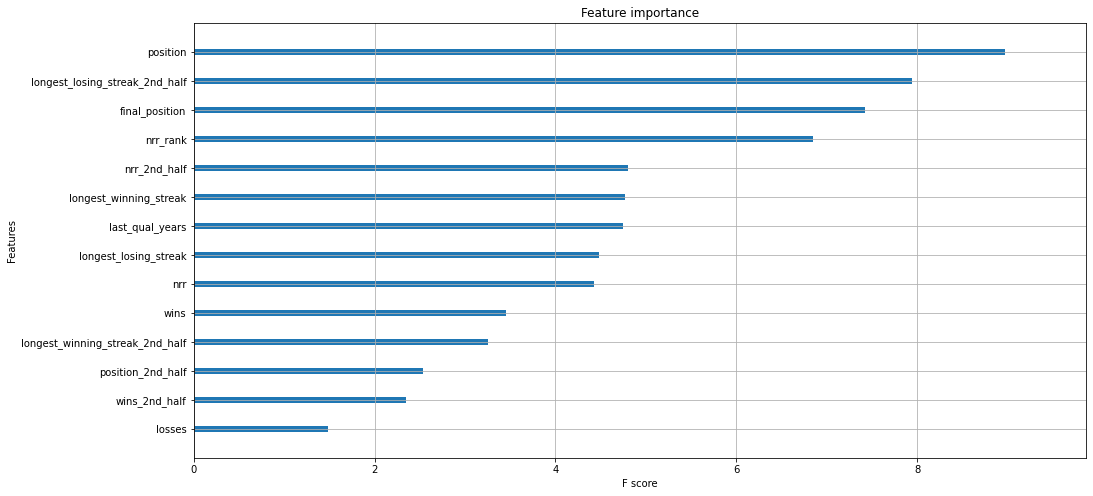

In [1165]:
# Handle class imbalance
class_weight = data.is_next_champion.value_counts()[0] / data.is_next_champion.value_counts()[1]

# Ref: Appendix A
model = XGBClassifier(use_label_encoder = False, scale_pos_weight = class_weight, eval_metric = 'auc', 
                      max_depth = 3, min_child_weight = 4, gamma = 0.8, reg_alpha = 0.01)
model.fit(X_train, y_train)

plt.rcParams["figure.figsize"] = (16, 8)
plot_importance(model, importance_type = 'gain', show_values = False)
plt.show()

## Evaluation

In [1166]:
# Make sure that exactly 1 team is predicted as the winner
y_pred = pd.DataFrame(model.predict_proba(X_test), columns = ['lose_prob', 'win_prob']).win_prob
y_pred = np.array(y_pred.groupby(y_pred.index // 8).apply(lambda x: (x == x.max()).astype(int)))
# y_pred.groupby(y_pred.index // 8).apply(pd.DataFrame.sort_values, 'win_prob', ascending = False)

roc_auc_score (train):  0.9705882352941176
roc_auc_score (test):  0.8095238095238093


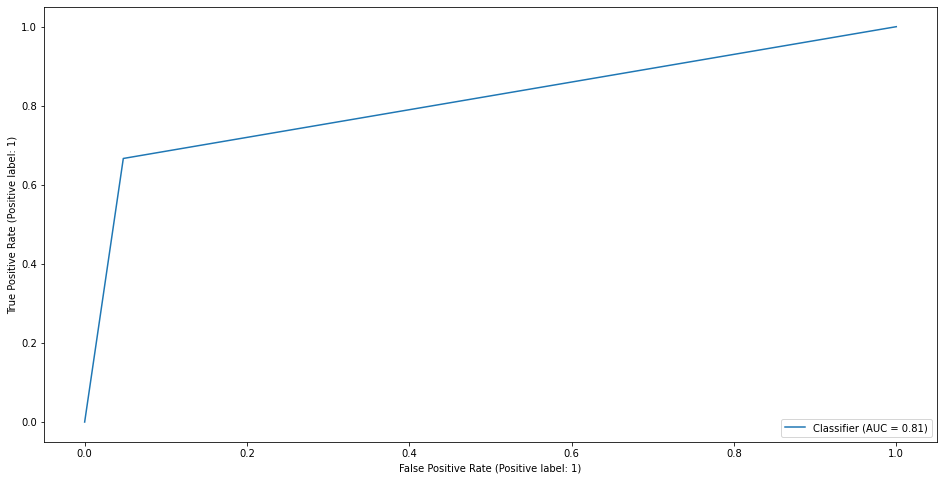

In [1167]:
print("roc_auc_score (train): ", metrics.roc_auc_score(y_train, model.predict(X_train)))
print("roc_auc_score (test): ", metrics.roc_auc_score(y_test, y_pred))
metrics.RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()

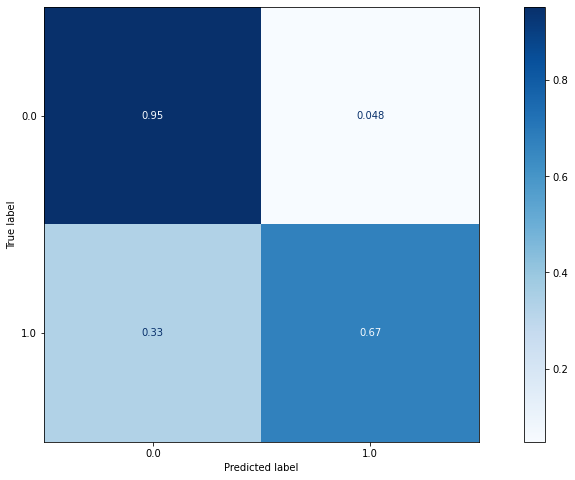

In [1170]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize = 'true', cmap = 'Blues')
plt.show()

In [1171]:
print(metrics.classification_report(y_train, model.predict(X_train)))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97        68
         1.0       0.69      1.00      0.82         9

    accuracy                           0.95        77
   macro avg       0.85      0.97      0.89        77
weighted avg       0.96      0.95      0.95        77

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95        21
         1.0       0.67      0.67      0.67         3

    accuracy                           0.92        24
   macro avg       0.81      0.81      0.81        24
weighted avg       0.92      0.92      0.92        24



## Testing

In [1172]:
# Use full model
X[continuous_features] = scaler.fit_transform(X[continuous_features])
model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0.8, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=4, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0.01, reg_lambda=1, scale_pos_weight=7.416666666666667,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [1173]:
X_new = data.iloc[-8:, 5:-3]
X_new = X_new.drop(columns = 'is_captain_overseas_next')

X_new[match_data_features] = X_new[match_data_features].div(X_new.matches, axis = 0)
X_new[match_data_features_2nd_half] = X_new[match_data_features_2nd_half].div(X_new.matches / 2, axis = 0)

X_new[continuous_features] = scaler.transform(X_new[continuous_features])
X_new

,num_teams_next,last_qual_years,final_position,matches,position,wins,losses,nr,points,nrr,...,longest_losing_streak,position_2nd_half,wins_2nd_half,losses_2nd_half,nr_2nd_half,points_2nd_half,nrr_2nd_half,nrr_rank_2nd_half,longest_winning_streak_2nd_half,longest_losing_streak_2nd_half
101,2.720151,-0.735197,1,-0.433861,2,1.048898,-0.968366,-0.482584,1.015195,0.873156,...,-0.131344,4,0.361412,-0.292221,-0.331497,0.329109,-0.442380,6,1.372739,0.506837
102,2.720151,-0.735197,2,-0.433861,4,0.024098,0.082594,-0.482584,-0.028747,1.133585,...,0.464870,1,1.102582,-1.044179,-0.331497,1.080297,2.343055,1,-0.316786,-0.925066
103,2.720151,-0.735197,3,-0.433861,1,1.561299,-1.493847,-0.482584,1.537165,0.924452,...,-1.323773,2,1.102582,-1.044179,-0.331497,1.080297,0.739835,2,0.527976,-0.925066
104,2.720151,-0.735197,4,-0.433861,3,1.048898,-0.968366,-0.482584,1.015195,-0.300747,...,-0.131344,3,0.361412,-0.292221,-0.331497,0.329109,-0.078076,5,0.527976,-0.209115
105,2.720151,-0.145872,5,-0.433861,5,0.024098,0.082594,-0.482584,-0.028747,0.204327,...,-0.131344,6,-0.379758,0.459736,-0.331497,-0.422078,0.247954,4,-0.316786,0.506837
106,2.720151,3.390076,6,-0.433861,6,-0.488302,0.608074,-0.482584,-0.550718,-0.026508,...,-0.131344,5,-0.379758,0.459736,-0.331497,-0.422078,0.389707,3,-1.161548,-0.209115
107,2.720151,1.032777,7,-0.433861,7,-1.000702,1.133555,-0.482584,-1.072689,-1.983671,...,-0.131344,8,-1.120927,1.211694,-0.331497,-1.173266,-2.537480,8,-1.161548,0.506837
108,2.720151,-0.145872,8,-0.433861,8,-2.025503,2.184515,-0.482584,-2.116631,-1.099791,...,1.061084,7,-1.120927,1.211694,-0.331497,-1.173266,-0.639416,7,-1.161548,-0.209115


In [1174]:
expected_outcome = pd.concat([data.iloc[-8:, 1].reset_index(drop = True), 
                              pd.DataFrame(model.predict_proba(X_new), columns = ['lose_prob', 'win_prob'])], 
                             axis = 1).sort_values('win_prob', ascending = False, ignore_index = True)

expected_outcome.index += 1
expected_outcome

,team,lose_prob,win_prob
1,Kolkata Knight Riders,0.147312,0.852688
2,Sunrisers Hyderabad,0.434081,0.565919
3,Delhi Capitals,0.890025,0.109975
4,Rajasthan Royals,0.924913,0.075087
5,Royal Challengers Bangalore,0.956324,0.043677
6,Mumbai Indians,0.981917,0.018083
7,Chennai Super Kings,0.982205,0.017795
8,Punjab Kings,0.987902,0.012098


## Appendix A: Tuning hyperparameters

In [1050]:
# Tune max_depth and min_child_weight
parameters = {
    'max_depth': range(1, 11),
    'min_child_weight': range(1, 6)
}

In [1054]:
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 42)
grid = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'roc_auc', n_jobs = -1, cv = cv)

In [1055]:
# execute the grid search
grid_result = grid.fit(X_train, y_train)

# report the best configuration
print("Best ROC AUC Score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best ROC AUC Score: 0.636722 using {'max_depth': 3, 'min_child_weight': 4}


In [1063]:
# Tune gamma
parameters = {
    'gamma': [i / 10 for i in range(0, 11)]
}

In [1064]:
grid = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'roc_auc', n_jobs = -1, cv = cv)

In [1065]:
# execute the grid search
grid_result = grid.fit(X_train, y_train)

# report the best configuration
print("Best ROC AUC Score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best ROC AUC Score: 0.665110 using {'gamma': 0.8}


In [1076]:
# Tune subsample and colsample_bytree
parameters = {
    'subsample': [i / 10 for i in range(1, 11)],
    'colsample_bytree': [i / 10 for i in range(1, 11)]
}

In [1077]:
grid = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'roc_auc', n_jobs = -1, cv = cv)

In [1078]:
# execute the grid search
grid_result = grid.fit(X_train, y_train)

# report the best configuration
print("Best ROC AUC Score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best ROC AUC Score: 0.665110 using {'colsample_bytree': 1.0, 'subsample': 1.0}


In [1094]:
# Tune reg_alpha and reg_lambda
parameters = {
    'reg_alpha': [0, 1e-2, 1e-1, 1, 10, 100],
    'reg_lambda': [0, 1e-2, 1e-1, 1, 10, 100]
}

In [1095]:
grid = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'roc_auc', n_jobs = -1, cv = cv)

In [1096]:
# execute the grid search
grid_result = grid.fit(X_train, y_train)

# report the best configuration
print("Best ROC AUC Score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best ROC AUC Score: 0.667674 using {'reg_alpha': 0.01, 'reg_lambda': 1}


In [1137]:
# Tune learning_rate
parameters = {
    'learning_rate': [1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1],
}

In [1138]:
grid = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'roc_auc', n_jobs = -1, cv = cv)

In [1139]:
# execute the grid search
grid_result = grid.fit(X_train, y_train)

# report the best configuration
print("Best ROC AUC Score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best ROC AUC Score: 0.667674 using {'learning_rate': 0.3}
